# Introduction to cointegration: theory and practice
This Notebook intends to serve as a guide for understanding cointegration between two time series and its properties and hypotheses. It combines the theory and mathematical background required to understand the cointegration as well as code snippets exemplifying the use of each feature.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

## 1. Need for a different set of tools
The concept of cointegration was developed by **Clive W.J. Granger** and **Robert F. Engle**; leading to them sharing a Nobel Prize in Economic Sciences in 2003.

**Working with non-stationary time series requires (in general) using non standard distributions**; as we saw in the research regarding the ADF test. This is due to the fact that **the variance of the slope estimator is underestimated when we fit a regression between two independent non-stationary time series**.

If we consider the basic model $y_t=\beta_0+\beta_1x_t+u_t$ where $u_t$ represents a series of gaussian white noise and $x_t$ is stationary, we can estimate $\beta_0$, $\beta_1$ and $\sigma^2$ based on ordinary least squares (OLS). In this case the variance of the slope estimator is measured by $\displaystyle Var(\hat{\beta_1})=\frac{\sigma^2_u}{Ts^2_x}$, where $\sigma^2_u$ is the variance of the noise ($u_t$); $T$ is the number of observations and $s^2_x$ represents the variance of the stationary process $x_t$. This expression can be interpreted as the ratio between noise variance and signal variance: the higher the signal to noise ratio, the more accurate the slope estimation.

However, let's consider now the model $y_t=\beta_0+\beta_1x_t+\epsilon_t$ where $\epsilon_t$ is not white noise any more but a general stationary process with dynamic structure. Now it can be proved that the expression for the variance of the slope estimator becomes $\displaystyle Var(\hat{\beta_1})=\frac{\sigma^2_\epsilon}{Ts^2_x}[1+2\sum^{T-1}_{t=1}(T-t)\rho_n(t)E(r_x(t))]$ where $\sigma^2_\epsilon$ represents the variance of the error term; $\rho_n(t)$ is the order $t$ autocorrelation coefficient of the error term and $r_x(t)$ is the order $t$ autocorrelation coefficient of the x variable.

We can notice that if $\epsilon_t$ is a white noise process, then $\rho_n(t)$ is zero and we end up with the first equation above. However, if $x_t$ and $\epsilon_t$ have positive autocorrelation, we would be underestimating the variance of the slope estimator if we use the basic equation. It is worth noting that if $x_t$ is a white noise process not correlated with $\epsilon_t$ then $E(r_x(t))$ equals zero and we end up again with the basic equation above. However; we would be using an inefficient estimator in this case, and we would be better off by using a **generalized least squares** estimator instead.

This phenomenon of spurious regression can be better exemplified by calculating the t-statistic for the slope estimator applied to regressions between two independent random walks. We will first generate two functions to simulate both a random walk and a stationary process.

In [ ]:
def generate_random_walk(size, loc=0, scale=1):
  """
  This function simulates a simple random walk based on
  gaussian white noise.

  :param size: number of time steps for the simulation.
  :param loc: mean for the gaussian distribution.
  :param scale: standard deviation for the gaussian distribution.
  :return: simulated random walk.
  """
  u_t = np.random.normal(loc=loc, scale=scale, size=size)
  x_t = u_t.cumsum()
  return x_t


def generate_stationary_process(size, loc=0, scale=1):
  """
  This function simulates a stationary process based on
  gaussian white noise.

  :param size: number of time steps for the simulation.
  :param loc: mean for the gaussian distribution.
  :param scale: standard deviation for the gaussian distribution.
  :return: simulated stationary process.
  """
  x_t = np.random.normal(loc=loc, scale=scale, size=size)
  return x_t

Then we will perform a misspecified t-statistic test to verify that, in effect, much more than the expected 5% of the statistics are greater in absolute value than the ±2 value in the t-student distribution.

In [ ]:
def calc_wrong_t_statistic(num_samples, size):
  """
  This function incorrectly calculates the slope t-statistic for
  two independent random walks as if they were stationary to
  prove the underestimation of the slope estimator's variance
  this methodology implies.

  :param num_samples: number of samples for the simulation.
  :param size: number of time steps for the simulation.
  :return: list containing all the t-statistics.
  """
  t_statistics = []
  # Iterate over the number of samples required
  for sample in range(num_samples):
    # Generate two independent random walks
    x_t = generate_random_walk(size)
    y_t = generate_random_walk(size)

    # Calculate the regression and the t-statistic
    slope, intercept, *__, slope_error = linregress(x_t, y_t)
    t_statistics.append(slope / slope_error)

  return t_statistics

t_statistics = calc_wrong_t_statistic(10_000, 1_000)

We now plot an histogram of the results where we have signaled the ±2 reference levels and we explicitly calculate the percentage of observation out of this range.

92% of samples pass the test (expected 5%)



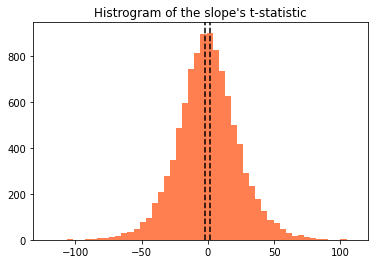

In [ ]:
def plot_hist_t_statistic(t_statistics):
  plt.hist(t_statistics, bins=50, color='coral')
  plt.title("Histrogram of the slope's t-statistic")
  plt.axvline(2, ls='--', c='k')
  plt.axvline(-2, ls='--', c='k')
  pct_out = (pd.Series(t_statistics).abs() > 2).mean()
  text_caption = str(int(pct_out*100)) + '% of samples pass the test (expected 5%)\n'
  print(text_caption)
  plt.show();

plot_hist_t_statistic(t_statistics)

However, if we perform the same test over two random independent stationary series we can verify that the relation holds and only approximately 5% of the points pass the test, as we would expect.

4% of samples pass the test (expected 5%)



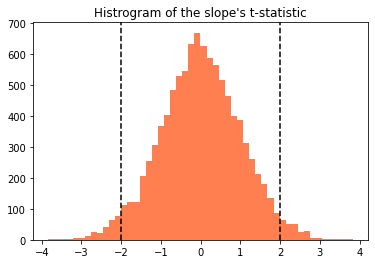

In [ ]:
def calc_right_t_statistic(num_samples, size):
  """
  This function incorrectly calculates the slope t-statistic for
  two independent random walks as if they were stationary to
  prove the underestimation of the slope estimator's variance
  this methodology implies.

  :param num_samples: number of samples for the simulation.
  :param size: number of time steps for the simulation.
  :return: list containing all the t-statistics.
  """
  t_statistics = []
  # Iterate over the number of samples required
  for sample in range(num_samples):
    # Generate two independent random walks
    x_t = generate_stationary_process(size)
    y_t = generate_stationary_process(size)

    # Calculate the regression and the t-statistic
    slope, intercept, *__, slope_error = linregress(x_t, y_t)
    t_statistics.append(slope / slope_error)

  return t_statistics

t_statistics = calc_right_t_statistic(10_000, 1_000)
plot_hist_t_statistic(t_statistics)

Therefore, we must develop alternative tests to detect when there is a relationship between two non-stationary series. For several years, the most usual solution was to differentiate the series to make them stationary and avoid the problem. However, this approach bears its own inconvenients, namely the loss in efficiency due to the decrease of the regressor variance and the increase in the noise variance, besides the introduction of a non-invertible moving average term in the perturbation.

<a name="cell-2"></a>
### 2 Concept of cointegration
We say a time series is integrated of order d or $I(d)$ if we need to apply $d$ differences to make it stationary or $I(0)$. Two time series $x_t$ and $y_t$, both of them $I(d)$, are said to be cointegrated if there exists a linear combination of them with and order of cointegration lower than $d$. That is, if it is possible to find $n_t^*=\alpha_1y_t+\alpha_2x_t$ where $n_t^*$ is a time series $I(d_1)$ with $d_1 < d$ and $\alpha_1, \alpha_2 \in\mathbb{R}$.

We refer to the combination ($\alpha1, \alpha2$) as a **cointegration relationship**. This cointegration relationship is not unique, since ($k\alpha1, k\alpha2$) also denotes a cointegration relationship for every $k\neq0$.

A cointegration relationship implies that one variable partially explains the trend in the other variable. Usually we divide the expression above by $\alpha_1$ and express the relationship as

$y_t = \beta x_t+n_t$

Where $\beta = -\alpha_2 / \alpha_1$ and $n_t = n^*_t/\alpha_1$ is an $I(d_1)$ process. Based on the equation above the cointegration relationship is said to be $(1, -\beta)$. In trading we interpret this cointegration relationship as **buying 1 units of asset A and selling $\beta$ units of asset B**.

In the financial markets all vanilla assets' prices represent usually $I(1)$ time series, that is, their change (differentiation of first order) is stationary. When two or more assets are $I(1)$ and a linear combination of them is stationary we find a particular case of cointegration specially relevant for trading.

Series of financial prices are usually examples of random walks, and therefore there is no inference we can perform on them. However, we can make a profit from mean reversion if we find stationary combinations of assets.

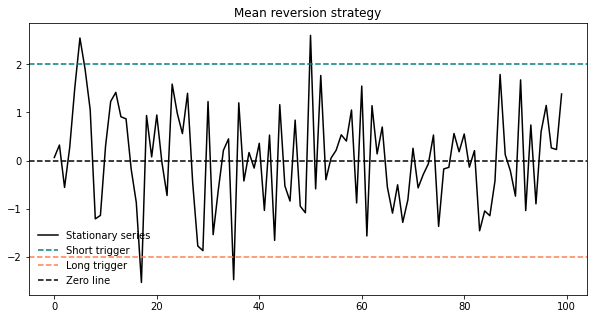

In [ ]:
x_t = generate_stationary_process(100, loc=0, scale=1)
plt.figure(figsize=(10,5))
plt.title('Mean reversion strategy')
plt.plot(x_t, c='black', label='Stationary series')
plt.axhline(2, ls='--', c='teal', label='Short trigger')
plt.axhline(-2, ls='--', c='coral', label='Long trigger')
plt.axhline(0, ls='--', c='black', label='Zero line')
plt.legend(frameon=False)
plt.show();

To find cointegration relationships there are mainly two methodologies: the **Engle Granger method** or CADF (Conditional Augmented Dickey-Fuller) and the **Johansen method**. The latter introduces the advantage of allowing the testing of cointegration relationships between up to 12 different assets.

We will develop independent presentations covering in detail both methodologies.

### References
[Análisis de series temporales - Daniel Peña
] https://drive.google.com/file/d/1arpbWS7HUgHz_frOFYTgfHwQr2hFsin_/view?usp=sharing<br/>